# Распространение тепла

### Условие задачи

**Дано:**
- пластина, в которой распространяется тепло от нескольких источников
  
- коэффициенты диффузии:
    -  основного материала (синий цвет) $D_0 = 1.0$
    -  включений (белый цвет) $D_1 = 10^{-2}$

- размер массива поля температур $NxN$, где $N \in [60, 120, 240, 480, 960]$

- $T_0 = 0$ - начальная температура во всем объеме пластины

- граничные условия на ребрах пластины двух видов:
    - фиксированная температура на ребрах
        - $x = 0$
        - $y = 0$
    - абсолютная теплоизоляция на ребрах
        - $x = 60$
        - $y = 60$

- в массе пластины расположены источники тепла, мощность которых меняется по периодическому закону:
    -  $\dot{q}_i = p_i \cdot (sin(\frac{2\pi}{\theta_i}t) + 1)$
    - источник 0: $p_0 = 100$, $\theta_0 = 43$
    - источник 1: $p_1 = 100$, $\theta_1 = 77$
    
- на пластине расположены 4 пробы (черные точки)
    
- $t_m = 600$ c - общее время моделирования

**Пример схемы пластины для варианта 0**

<img src="var_00.png" width=600/>


**Требуется:**
- согласно уравнению диффузии смоделировать распространение тепла в пластине на заданное время $t_m$ для каждого $N$
- шаг по времени $dt$ подобрать самостоятельно так, чтобы расчетная схема сходилась
- для каждого $N$:
    1. вывести время расчета
    
    2. сохранить в файл(ы) и использовать в пунктах 3-5:
        - температурное поле в конечный момент времени
        - замеры температуры в местах установки проб
        - **сохраненные файлы НЕ загружать в классрум**
    
    3. построить изображение матрицы коэффициентов диффузии

    4. построить цветовую карту поля температур в конечный момент времени
        - подписать оси,
        - отобразить цветовую шкалу `colorbar`,
        - отобразить пробы в виде точек и подписать их номера.

    5. на одном рисунке построить графики температур в местах установки всех четырех проб
        - подписать оси,
        - вывести легенду.

    6. используя быстрое преобразование Фурье, восстановить периоды колебаний температуры в местах установки проб
        - `np.fft.rfft`, `np.fft.rfftfreq`, `scipy.signal.find_peaks`

    7. задокументировать все функции


**Материалы:**

- [Уравнение теплопроводности](https://ru.wikipedia.org/wiki/Уравнение_теплопроводности)
- [Solving 2D heat equation numerically using python](https://levelup.gitconnected.com/solving-2d-heat-equation-numerically-using-python-3334004aa01a)
- [Diffusion Eq 2D with Source](https://www.youtube.com/watch?v=aCRYfvh_bnY)


**Правила оценивания:**

- оценка за корректно выполненный расчет для $N$, баллов из 100:
```
    N    =   60,  120, 240, 480, 960
    g(N) =    5,    5,  10,  30,  50
```
    
- штрафы $p(i)$, баллов:
    - не выведено время расчета - 20
    - не выполнено сохранение результатов в файл(ы) - 20
    - построение графиков не использует сохраненные результаты - 20
    - не построены графики температур в местах установки проб - 20
    - не построена карта поля температур - 20
    - не построена карта коэффициентов диффузии - 10
    - не посчитаны периоды колебаний - 20
    - отсутствует документация функций - 20
    - менее значимые недоработки - 10


- итоговая оценка за задание = $\sum_{k=1}^{4}{g(N_k)} - \sum_{i}{p(i)}$


In [2]:
from IPython.display import Image

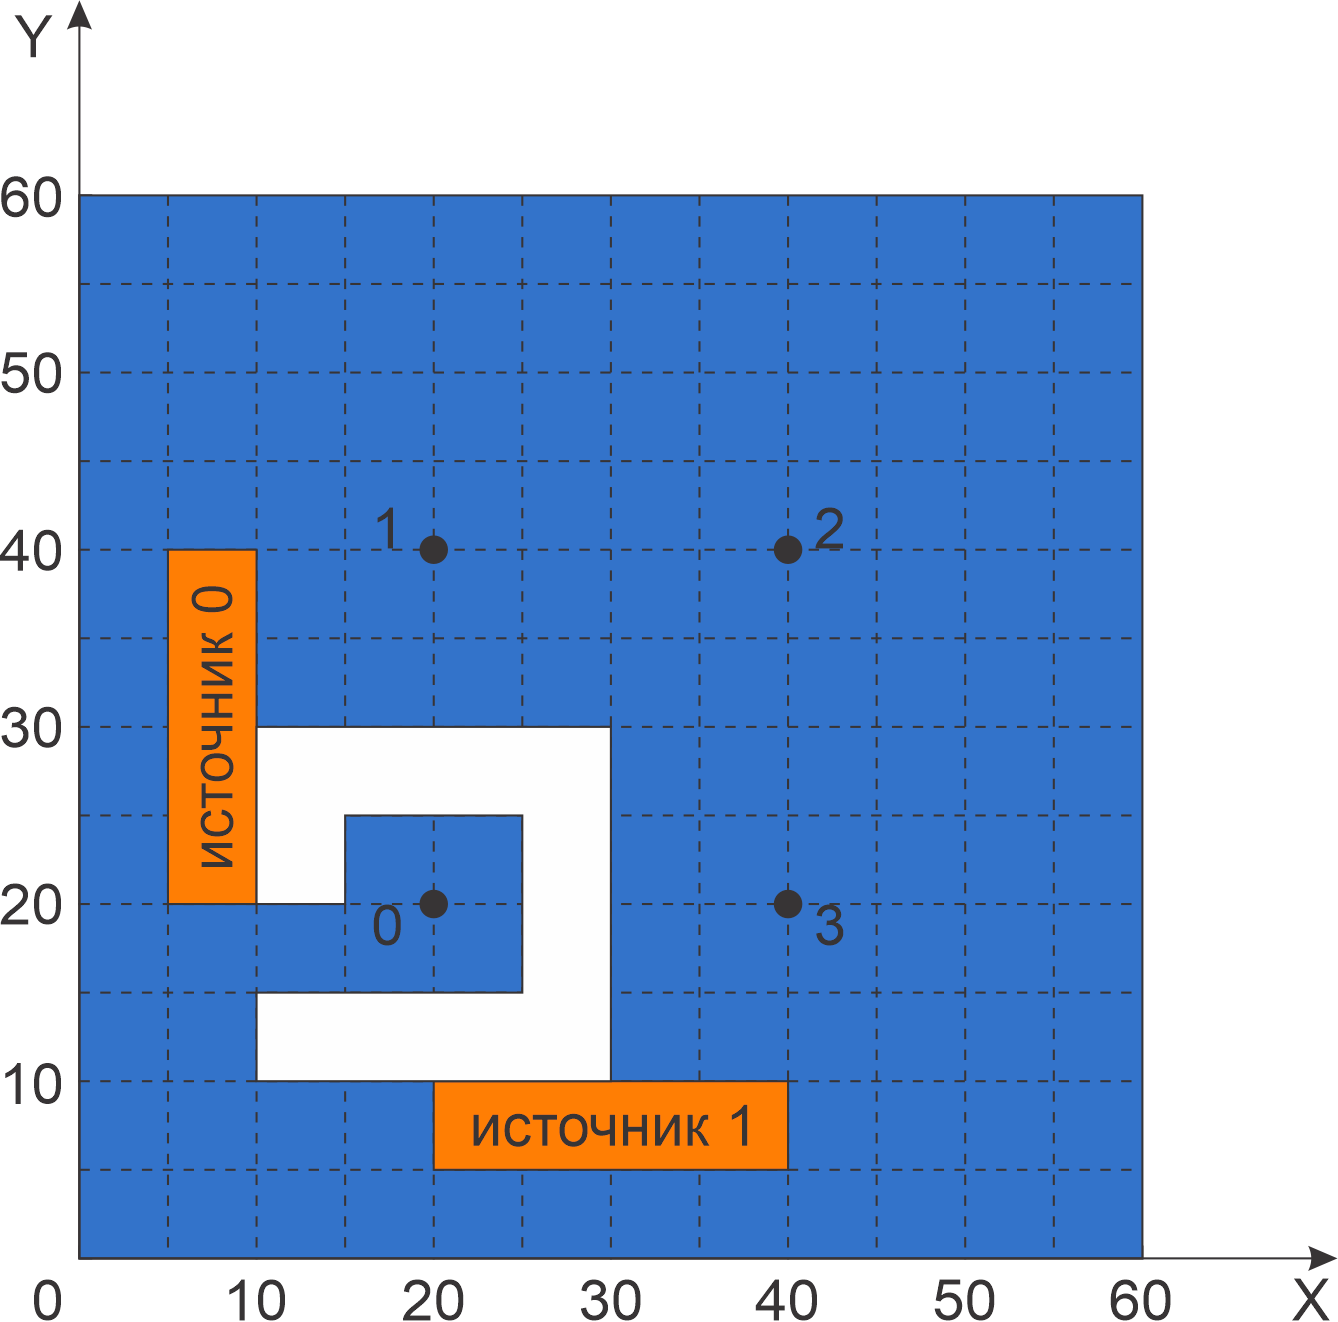

In [3]:
display(Image(filename="./task.png"))

# Решение

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

In [39]:
def create_D_matrix(L, N, D_blue, D_white):
    D_coord = np.full((L, L), D_blue)
    D_coord[10:15, 10:30] = D_white
    D_coord[15:30, 25:30] = D_white
    D_coord[25:30, 10:30] = D_white
    D_coord[20:25, 10:15] = D_white

    D = np.full((N, N), D_blue)

    multiplier = int(N / L)

    for ix in range(len(D_coord)):
        for iy in range(len(D_coord[0])):
            Diff = D_coord[ix][iy]
            new_dy, new_dx = int(iy * multiplier), int(ix * multiplier)
            D[new_dy:new_dy + int(multiplier) + 1, new_dx:new_dx + int(multiplier) + 1] = Diff
    return D

In [40]:
def boundary_conditions(T: np.ndarray):
    """
    Абсолютная теплоизоляция + нулевая температура
    """
    T[:, -1, :] = T[:, -2, :]
    T[:, :, -1] = T[:, :, -2]
    T[:, :, 0] = 0.0
    T[:, 0, :] = 0.0

def calc_q_0(t):
    """
    Считаем как нагрелся источник № 0
    :param dt:
    :return:
    """
    p0, tetta0 = 100, 43
    return p0 * (np.sin(2 * np.pi * t / tetta0) + 1)


def calc_q_1(t):
    """
    Считаем как нагрелся источник № 1
    :param dt:
    :return:
    """
    p1, tetta1 = 100, 77
    return p1 * (np.sin(2 * np.pi * t / tetta1) + 1)

def heat_sources(T: np.ndarray,
                 dt: float,
                 it,
                 N,
                 L
                 ):
    """
    Нагреваем источники
    :param T:
    :param dt:
    :return:
    """
    q0 = calc_q_0(dt * it)
    q1 = calc_q_1(dt * it)
    m = int(N / L)
    T[:, 20 * m:40 * m + m, 5 * m:10 * m + m] += q0 * dt
    T[:, 5 * m:10 * m + m, 20 * m:40 * m + m] += q1 * dt

def diffuse_step(
        it: int,
        T: np.ndarray,
        dx: float,
        dt: float,
        D: np.ndarray
):
    """
    Считаем как распостранилось тепло от источников
    :param it:
    :param T:
    :param dx:
    :param dt:
    :param D:
    :return:
    """
    prev = it % 2
    cur = prev - 1
    g = dt * D[1:-1, 1:-1] / dx ** 2

    T[cur, 1:-1, 1:-1] = T[prev, 1:-1, 1:-1] + g * (
            T[prev, 1:-1, 0:-2] +
            T[prev, 1:-1, 2:] +
            T[prev, 0:-2, 1:-1] +
            T[prev, 2:, 1:-1] -
            4 * T[prev, 1:-1, 1:-1]
    )

100%|██████████| 384000/384000 [12:26<00:00, 514.16it/s]  


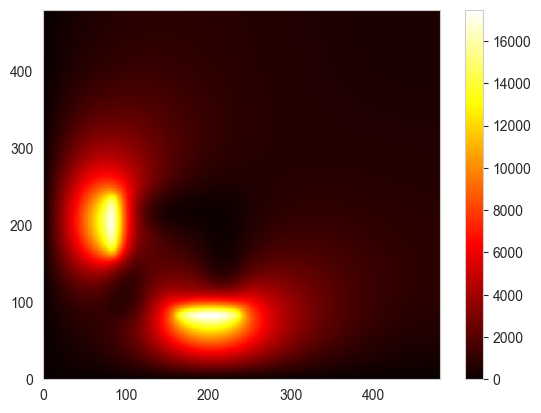

In [45]:
def main_function(N):

    D_blue = 1.0  # коэфф. диффузии
    D_white = 0.01  # коэфф. диффузии

    L = 60

    dx = L / N  # размер одного разбиения
    multiplier = int(N / L)

    D = create_D_matrix(L, N, D_blue, D_white)
    T = np.zeros((2, N, N))
    Points = [
        [20 * multiplier, 20 * multiplier],
        [20 * multiplier, 40 * multiplier],
        [40 * multiplier, 20 * multiplier],
        [40 * multiplier, 40 * multiplier]
    ]

    tmax = 600  # время моделирования (в сек.) (ЗАМЕНИТЬ НА 600)
    C = 0.1  # числов Курранта
    dt = C * dx ** 2 / D_blue  # почему?
    it_max = int(tmax / dt)  # it_max = int(tmax / dt)
    # it_max = 100000

    point_values = [[],[],[],[]]

    for it in trange(it_max):
        heat_sources(T, dt, it, N, L)
        boundary_conditions(T)
        diffuse_step(it, T, dx, dt, D)
        for point in Points:
            point_values[Points.index(point)].append(T[it % 2 - 1, point[0], point[1]])

    T_final = T[it_max % 2 - 1, :, :]
    with open(f'file_{N}.npy', 'wb') as file:
        np.save(file, T_final)
        np.save(file, point_values)

    plt.pcolormesh(T[0], cmap='hot')
    plt.colorbar()

    return point_values


N_list = [480] # [60, 120, 240, 480, 960]
for N in N_list:
     main_function(N)

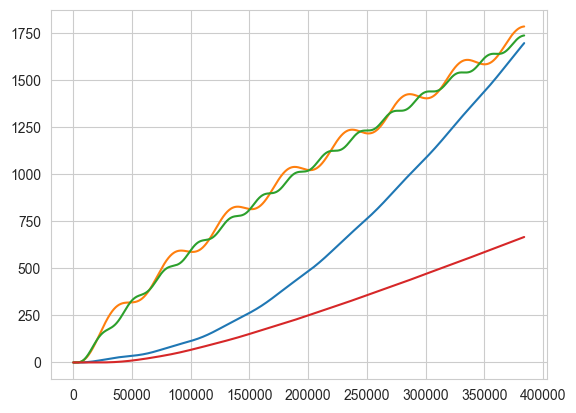

4


In [46]:
for N in N_list:
    with open(f'file_{N}.npy', 'rb') as file:
        T = np.load(file)
        point_values = np.load(file)
        for point_value in point_values:
            plt.plot(point_value)
        plt.show()
        print(len(point_values))